In [1]:
import sys 
import os
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
import memote
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product

from scipy.stats import kruskal
from multiprocessing import Pool


#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src")


# #Change working dir first, ty ChatGPT, much loves
# cwd = os.getcwd()
# # Split the path into a list of directories
# directories = cwd.split(os.sep)
# # Remove the last two directories from the list
# directories = directories[:-2]
# # Join the directories back into a path
# new_cwd = os.sep.join(directories)
# # Change the current working directory to the new path
# os.chdir(new_cwd)

# sys.path.append("./src")


In [2]:

#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the 
Gelman-Rubin and Geweke statistics as well as 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions


In [246]:
'''This code block contains functions that we need to use to analyze our flux sampling experiment. 
These include tests to check for convergence, for autocorrelation, as well as for pairwise comparisons of fluxes between
parametization regimens (WT, TR, as well as 3 light conditions) and a script to determine whether fluxes are
coupled with each other.
'''


def load_csv_and_cleanup(filename):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean of 0
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < 1e-6].index
    print(columns_to_remove)
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    

def gelman_rubin_convergence(df, threshold=1.1):
    # Get flux columns
    flux_columns = [col for col in df.columns]

    # Calculate the Gelman-Rubin statistics (R-hat) for each column
    r_hat_values = []
    for col in flux_columns:
        chain_values = df[col].values.reshape(-1, 1)  # Reshape values into a 2D array (for potential future extensions)
        n_chains = chain_values.shape[1]  # Number of chains
        n_samples = chain_values.shape[0]  # Number of samples

        # Calculate the within-chain variance
        within_chain_var = np.var(chain_values, axis=0, ddof=1)

        
        # Calculate the between-chain variance
        mean_chain_values = np.mean(chain_values, axis=0)
        between_chain_var = n_samples / (n_chains - 1) * np.sum((chain_values - mean_chain_values) ** 2)

        # Calculate the pooled variance
        pooled_var = within_chain_var + between_chain_var / n_samples

        # Calculate the potential scale reduction factor (R-hat)
        r_hat = np.sqrt(pooled_var / within_chain_var)
            
        r_hat_values.append(r_hat)


    converged_fluxes = sum(1 for r_hat in r_hat_values if r_hat <= threshold)
    total_fluxes = len(flux_columns)

    # Calculate the percentage of converged fluxes
    percentage_converged = (converged_fluxes / total_fluxes) * 100

    return percentage_converged


    
def geweke_convergence(df, threshold=1.96):
    # Get the list of flux parameter columns
    flux_columns = df.columns.tolist()

    # Calculate the Geweke diagnostic for each column
    geweke_values = []
    for col in flux_columns:
        chain_values = df[col].values
        n_samples = chain_values.shape[0]

        # Calculate the Geweke diagnostic
        first_segment = chain_values[:int(n_samples * 0.1)]  # First 10th percentile
        last_segment = chain_values[int(n_samples * 0.5):]  # Last 50th percentile
        z_scores = (np.mean(first_segment) - np.mean(last_segment)) / np.sqrt(np.var(first_segment) + np.var(last_segment))

        geweke_values.append(z_scores)

    # Determine the convergence based on the Geweke diagnostic
    converged_fluxes = sum(np.abs(geweke_values) < threshold)  # Assuming |z-score| < 1.96 indicates convergence (for 0.95 confidence interval)
    total_fluxes = len(flux_columns)

    # Calculate the percentage of converged fluxes
    percentage_converged = (converged_fluxes / total_fluxes) * 100

    return percentage_converged



def calculate_psrf(df, threshold=2):
    # Get the number of chains and samples
    n_chains = df.shape[1]
    n_samples = df.shape[0]

    # Calculate the within-chain variance
    within_chain_var = df.var(axis=0, ddof=1)

    # Calculate the between-chain variance
    mean_chain_values = df.mean(axis=0)
    mean_values = mean_chain_values.mean(axis=0)
    between_chain_var = n_samples / (n_chains - 1) * np.sum((mean_chain_values - mean_values) ** 2, axis=0)

    # Calculate the pooled variance
    pooled_var = (n_samples - 1) / n_samples * within_chain_var + between_chain_var / n_samples

    # Calculate the potential scale reduction factor (PSRF)
    psrf = np.sqrt(pooled_var / within_chain_var)

    # Determine the convergence based on the PSRF values
    converged_reactions = np.sum(psrf <= threshold, axis=0)
    total_reactions = df.shape[1]

    # Calculate the percentage of converged reactions per column
    percentage_converged = (converged_reactions / total_reactions) * 100

    return percentage_converged



def compare_pair(reaction, df1, df2, significance_threshold):
    """
    Compare the flux distributions of a pair of columns from two dataframes using the Kruskal-Wallis test.

    :param pair: Tuple containing the pair of column names.
    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test.
    :return: The pair and the result of the Kruskal-Wallis test.
    """
    sample1 = df1[reaction]
    sample2 = df2[reaction]
    H, pval = kruskal(sample1, sample2)
    return pval 

def compare_flux_distributions(df1, df2, significance_threshold=0.05):
    """
    Compare the flux distributions of each pair of columns from two dataframes using the Kruskal-Wallis test.

    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test (default: 0.05).
    :return: A list of pairs with significantly different distributions.
    """
    common_columns = set(df1.columns) & set(df2.columns)
    
    pool = multiprocessing.Pool()
    sig_results = []
    non_sig_results = []
    
    for rxn in common_columns:
        kw_pval = compare_pair(rxn, df1, df2, significance_threshold) #This does the Kruskal-Wallis part
        if kw_pval < significance_threshold:
            sig_results.append(rxn)
        else:
            non_sig_results.append(rxn)
            
    
    return sig_results, non_sig_results


def calculate_coupling(chunk, flux_samples_df):
    coupling_matrix = np.zeros((len(chunk), len(flux_samples_df.columns)))

    for i, reaction_i in enumerate(chunk):
        for j, reaction_j in enumerate(flux_samples_df.columns):
            flux_i = flux_samples_df[reaction_i]
            flux_j = flux_samples_df[reaction_j]
            coupling_matrix[i, j] = np.corrcoef(flux_i, flux_j)[0, 1]

    return coupling_matrix

def analyze_flux_coupling(flux_samples_df):
    # Get the reactions from the column names
    reactions = flux_samples_df.columns.tolist()

    # Define the number of processes to use
    num_processes = multiprocessing.cpu_count()

    # Split the reactions into chunks for parallel processing
    chunks = np.array_split(reactions, num_processes)

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Calculate flux coupling coefficients using parallel processing
    results = pool.starmap(calculate_coupling, [(chunk, flux_samples_df) for chunk in chunks])

    # Concatenate the results from all processes
    flux_coupling_matrix = np.concatenate(results, axis=0)

    # Create a DataFrame to store the flux coupling coefficients
    flux_coupling_df = pd.DataFrame(data=flux_coupling_matrix, index=reactions, columns=reactions)

    # Extract positively and negatively correlated reactions
    positively_correlated = []
    negatively_correlated = []
    uncoupled = []

    for i, reaction_i in enumerate(reactions):
        coupled_reactions = flux_coupling_df.columns[(flux_coupling_df.iloc[i] != 0) & (flux_coupling_df.iloc[i] != 1)].tolist()
        if len(coupled_reactions) > 0:
            if flux_coupling_df[reaction_i].mean() > 0:
                positively_correlated.append((reaction_i, coupled_reactions))
            else:
                negatively_correlated.append((reaction_i, coupled_reactions))
        else:
            uncoupled.append(reaction_i)

    return positively_correlated, negatively_correlated, uncoupled


#The script above is used for flux coupling using the opened CSV file as input and outputs 3 lists:
#positively correlated, neg. correlated and uncoupled reactions



def generate_histograms(dataframe1, dataframe2, column_name):
    # Create subplots for two histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Histogram for dataframe1
    axes[0].hist(dataframe1[column_name], bins=10, color='skyblue')
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Histogram for dataframe2
    axes[1].hist(dataframe2[column_name], bins=10, color='lightgreen')
    axes[1].set_title(f'Histogram of {column_name}')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()


In [97]:
#Test the script on one CSV

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_250.csv')
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_750.csv')
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_1500.csv')
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_250.csv')
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_750.csv')

tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_1500.csv')


Index(['Coleoptile_Biomass_M', 'Straw_Biomass_M', 'ACCOAC_OSAr_M',
       'ACPC_OSs_M', 'FAC_Osc_M', 'FAC_Osr_M', 'EX_h2o(e)', 'EX_pi(e)',
       'EX_sucr(e)', 'EX_fru-B(e)',
       ...
       'tre6p_pd', 'b-glucan_pd', 'mnt_pd', 'melib_pd', 'stc_pd', 'raffin_pd',
       '1Dgali_pd', 'inost_pd', 'oxa_pd', 'succ_pd'],
      dtype='object', length=3093)
(5012, 699)
Index(['Coleoptile_Biomass_M', 'Straw_Biomass_M', 'ACCOAC_OSAr_M',
       'ACPC_OSs_M', 'FAC_Osc_M', 'FAC_Osr_M', 'EX_h2o(e)', 'EX_pi(e)',
       'EX_sucr(e)', 'EX_fru-B(e)',
       ...
       'tre6p_pd', 'b-glucan_pd', 'mnt_pd', 'melib_pd', 'stc_pd', 'raffin_pd',
       '1Dgali_pd', 'inost_pd', 'oxa_pd', 'succ_pd'],
      dtype='object', length=3048)
(5012, 688)
Index(['Coleoptile_Biomass_M', 'Straw_Biomass_M', 'ACPC_OSs_M', 'EX_sucr(e)',
       'EX_fru-B(e)', 'EX_glc-A(e)', 'EX_so4(e)', 'EX_hco3(e)', 'EX_so3(e)',
       'EX_h2s(e)',
       ...
       'DM_h(c)_BS', 'DM_h(s)_BS', 'DM_h(x)_BS', 'DM_h(m)_BS', 'DM_h(u)_BS',
     

In [99]:
gelman_rubin_convergence(wt_250, 2.0)
gelman_rubin_convergence(wt_750, 2.0)
gelman_rubin_convergence(wt_1500, 2.0)

ZeroDivisionError: division by zero

In [198]:
print(geweke_convergence(wt_250, threshold=1.24))
print(geweke_convergence(wt_750, threshold=1.24))
print(geweke_convergence(wt_1500, threshold=1.24))
print(geweke_convergence(tr_250, threshold=1.24))
print(geweke_convergence(tr_750, threshold=1.24))
print(geweke_convergence(tr_1500, threshold=1.24))

100.0
100.0
100.0
100.0
100.0
100.0


In [118]:
print(calculate_psrf(wt_250, 2.0))
print(calculate_psrf(wt_750, 2.0))
print(calculate_psrf(wt_1500, 2.0))

#I don't think this method is an appropriate method? The ipsrsf is the better method of choice since it doesn't assume a normal distribution


4.86409155937053
4.3604651162790695
2.328099621007038


In [141]:
brooks_gelman_statistic(wt_250, 'DM_Phloem_BS')

IndexError: tuple index out of range

In [ ]:
WT250_750_sig_pairs = compare_flux_distributions(wt_250, wt_750)

(array([  3.,   4.,   9.,  17.,  39.,  69.,  84., 127., 176., 221., 267.,
        323., 370., 404., 421., 367., 428., 336., 320., 237., 210., 165.,
        151.,  99.,  70.,  39.,  24.,  20.,   6.,   4.,   1.,   0.,   1.]),
 array([23.44878493, 23.50770466, 23.56662439, 23.62554412, 23.68446385,
        23.74338358, 23.80230332, 23.86122305, 23.92014278, 23.97906251,
        24.03798224, 24.09690197, 24.1558217 , 24.21474143, 24.27366116,
        24.33258089, 24.39150063, 24.45042036, 24.50934009, 24.56825982,
        24.62717955, 24.68609928, 24.74501901, 24.80393874, 24.86285847,
        24.9217782 , 24.98069793, 25.03961767, 25.0985374 , 25.15745713,
        25.21637686, 25.27529659, 25.33421632, 25.39313605]),
 <BarContainer object of 33 artists>)

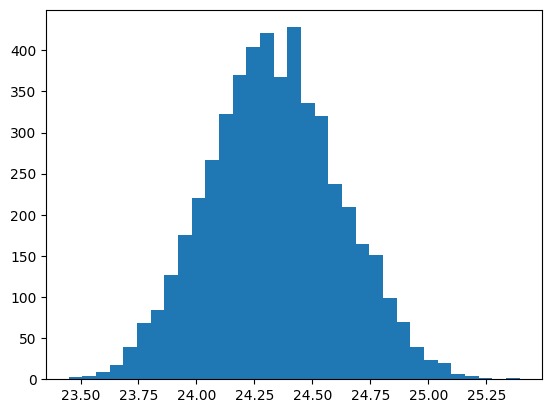

In [195]:
plt.hist(wt_750['RBPCs_M'], bins=33)
# plt.hist(wt_750['DM_Phloem_BS'], bins=33, label='WT-750PPFD')

(array([  1.,  12.,  15.,  22.,  46.,  60.,  92., 140., 164., 253., 274.,
        326., 347., 358., 357., 394., 345., 317., 289., 270., 245., 171.,
        138., 108.,  91.,  67.,  48.,  29.,  14.,   6.,  10.,   1.,   2.]),
 array([23.40773132, 23.46703333, 23.52633535, 23.58563737, 23.64493939,
        23.7042414 , 23.76354342, 23.82284544, 23.88214746, 23.94144947,
        24.00075149, 24.06005351, 24.11935553, 24.17865755, 24.23795956,
        24.29726158, 24.3565636 , 24.41586562, 24.47516763, 24.53446965,
        24.59377167, 24.65307369, 24.7123757 , 24.77167772, 24.83097974,
        24.89028176, 24.94958377, 25.00888579, 25.06818781, 25.12748983,
        25.18679184, 25.24609386, 25.30539588, 25.3646979 ]),
 <BarContainer object of 33 artists>)

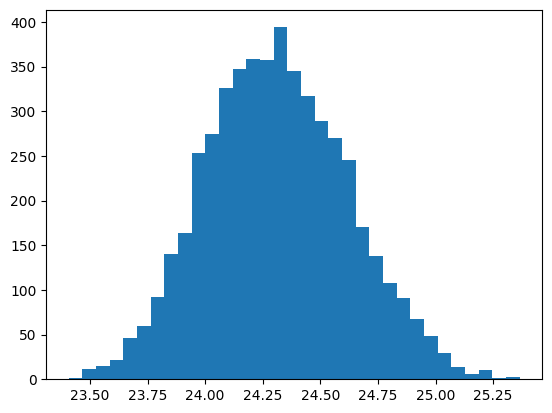

In [196]:
plt.hist(tr_750['RBPCs_M'], bins=33)
# plt.hist(wt_750['DM_Phloem_BS'], bins=33, label='WT-750PPFD')

In [201]:
wt_250_POSC, wt_250_NEGC, wt_250_NONC = analyze_flux_coupling(wt_250)

In [207]:
def print_columns(list1, list2, list3):
    max_length = max(len(list1), len(list2), len(list3))
    
    print("Column 1\tColumn 2\tColumn 3")
    print("=========\t=========\t=========")
    
    for i in range(max_length):
        col1 = list1[i] if i < len(list1) else ""
        col2 = list2[i] if i < len(list2) else ""
        col3 = list3[i] if i < len(list3) else ""
        
        print(f"{col1}\t\t{col2}\t\t{col3}")
        

print(len(wt_250_POSC), len(wt_250_NEGC), len(wt_250_NONC))


402 297 0


In [224]:
for rows in wt_250_NEGC:
    if rows[0] == 'DM_Phloem_BS':
        for items in rows[1]:
            print(items)

In [166]:
np.mean(wt_1500['DM_Phloem_BS'])

0.46700338707025946

In [165]:
np.mean(tr_1500['DM_Phloem_BS'])

0.35749913194727245

In [314]:
kw_sig, kw_non_sig =compare_flux_distributions(wt_250, tr_1500, significance_threshold=0.001)

In [318]:
print(len(kw_non_sig))

for rxn in kw_non_sig:
    reaction = wt_model.reactions.get_by_id(rxn)
    print('reaction id: ', reaction.id)
    print('reaction name: ', reaction.name)
    groups = reaction.notes.get('SUBSYSTEM', '')
    print('reaction groups: ', groups)

4
reaction id:  FRNCTIc_BS
reaction name:  (2E,6E)-farnesol 2-cis-trans-isomerase
reaction groups:  Terpenoid biosynthesis (Monoterpenoid biosynthesis)
reaction id:  FRORc_BS
reaction name:  2-trans,6-trans-farnesol:NADP+ 1-oxidoreductase
reaction groups:  Terpenoid biosynthesis (Monoterpenoid biosynthesis)
reaction id:  HCO3(h)tmi_M
reaction name:  hco3 transport, mitochondria
reaction groups:  Transport (Mitochondrial)
reaction id:  HCO3Em_M
reaction name:  carbonic anhydrase, mitochondrial
reaction groups:  Nitrogen metabolism


In [ ]:
#Flux sampling at low, medium and high light regimens

#Light treatments at 250 PPFD, 750 PPFD and 1500 PPFD





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.

Only 4 reactions were found to have constant when comparing between the Trans high light and WT low light 
